In [67]:
import ccxt
import pandas as pd
from datetime import datetime, timedelta
import plotly.graph_objects as go
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import praw
import datetime
import time
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from textblob import TextBlob
from collections import Counter

In [68]:
exchange = ccxt.binanceus()
markets = exchange.load_markets()
DOGE_markets = [market for market in markets if 'DOGE' in market]

DOGE_markets

['DOGE/USDT', 'DOGE/USD4', 'DOGE/BTC', 'DOGE/USD']

In [69]:
symbol = 'DOGE/USDT'
timeframe = '1h'
limit_per_request = 1000

In [70]:
start_date = datetime.datetime(2024, 8, 4, 19, 0)
end_date = datetime.datetime(2025, 1, 31, 18, 0)


start_timestamp = int(start_date.timestamp() * 1000)
end_timestamp = int(end_date.timestamp() * 1000)

all_ohlcv = []
current_timestamp = start_timestamp

while current_timestamp < end_timestamp:
    try:
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=current_timestamp, limit=limit_per_request)

        if not ohlcv:
            print(f"No more data available after {datetime.utcfromtimestamp(current_timestamp / 1000)}")
            break

        all_ohlcv.extend(ohlcv)


        current_timestamp = ohlcv[-1][0]


        exchange.sleep(1000)

    except Exception as e:
        print(f"Error fetching data: {e}")
        break


df = pd.DataFrame(all_ohlcv, columns=["timestamp", "open", "high", "low", "close", "volume"])

df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")


df = df[(df["timestamp"] >= start_date) & (df["timestamp"] <= end_date)]

df = df.reset_index(drop=True)

df.index = range(len(df))


In [71]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df = df.drop_duplicates(subset=['timestamp'])
df = df.sort_values(by='timestamp').reset_index(drop=True)
df

,timestamp,open,high,low,close,volume
0,2024-08-04 19:00:00,0.10291,0.10538,0.10243,0.10484,33372.0
1,2024-08-04 20:00:00,0.10479,0.10592,0.10419,0.10504,176645.0
2,2024-08-04 21:00:00,0.10469,0.10500,0.10439,0.10448,153458.0
3,2024-08-04 22:00:00,0.10480,0.10575,0.10480,0.10529,14575.0
4,2024-08-04 23:00:00,0.10504,0.10504,0.10364,0.10366,24668.0
...,...,...,...,...,...,...
4315,2025-01-31 14:00:00,0.33698,0.33734,0.33097,0.33273,25940.0
4316,2025-01-31 15:00:00,0.33248,0.33926,0.33248,0.33926,714977.0
4317,2025-01-31 16:00:00,0.33845,0.33963,0.33624,0.33826,23147.0
4318,2025-01-31 17:00:00,0.33755,0.33756,0.33338,0.33338,52885.0


In [74]:
def lppl(t, A, B, C, tc, beta, omega, phi):
    """
    Log-Periodic Power Law (LPPL) function for modeling financial bubbles.
    """
    return A + B * (tc - t)**beta * (1 + C * np.cos(omega * np.log(tc - t) + phi))

In [77]:
df['bubble_flag'] = 0
df.loc[df.index[peaks], 'bubble_flag'] = 1

In [78]:
df['bubble_period'] = (df['bubble_flag'].diff() != 0).cumsum() * df['bubble_flag']

bubble_periods = df[df['bubble_period'] > 0].groupby('bubble_period').filter(lambda x: len(x) > 3)

bubble_ranges = bubble_periods.groupby('bubble_period').agg({'close': ['idxmin', 'idxmax']})
bubble_ranges.columns = ['start_date', 'end_date']
bubble_ranges.reset_index(drop=True, inplace=True)

bubble_ranges

,start_date,end_date


In [79]:
df.set_index('timestamp', inplace=True)
df_nov_onwards = df.copy()

In [80]:
df_nov_onwards["time"] = (df_nov_onwards.index - df_nov_onwards.index[0]).total_seconds() / (60 * 60)

t_data = df_nov_onwards["time"].values
p_data = df_nov_onwards["close"].values

In [81]:
t_data

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 4.317e+03, 4.318e+03,
       4.319e+03])

In [82]:
tc_guess = t_data[-1] + 100
beta_guess = 0.5
omega_guess = 10
phi_guess = 0
A_guess = np.mean(p_data)
B_guess = -0.1 * A_guess
C_guess = 0.1
initial_params = [A_guess, B_guess, C_guess, tc_guess, beta_guess, omega_guess, phi_guess]

In [83]:
bounds = ([0, -np.inf, -1, t_data[-1], 0, 0, -np.pi], [np.inf, np.inf, 1, t_data[-1] + 500, 1, 50, np.pi])
opt_params, _ = curve_fit(lppl, t_data, p_data, p0=initial_params, bounds=bounds, maxfev=50000)

In [84]:
A_opt, B_opt, C_opt, tc_opt, beta_opt, omega_opt, phi_opt = opt_params

In [85]:
t_fit = np.linspace(t_data[0], tc_opt, 500)
p_fit = lppl(t_fit, *opt_params)

<ipython-input-74-a2c61a4b2f48>:5: RuntimeWarning:

divide by zero encountered in log

<ipython-input-74-a2c61a4b2f48>:5: RuntimeWarning:

invalid value encountered in cos



In [86]:
t_fit = np.linspace(t_data[0], tc_opt, 500)

In [87]:
t_fit = np.linspace(t_data[0], tc_opt - 1e-5, 500)

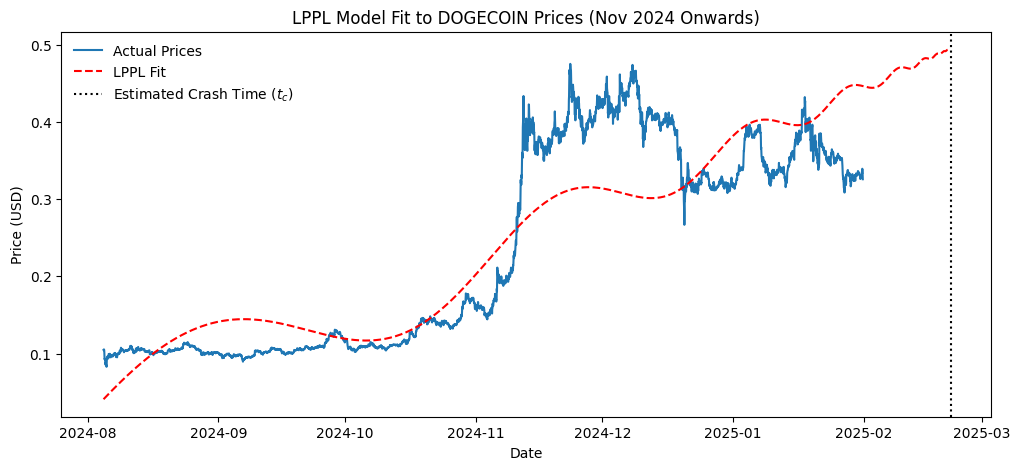

In [91]:
plt.figure(figsize=(12, 5))
plt.plot(df_nov_onwards.index, df_nov_onwards["close"], label="Actual Prices", linewidth=1.5)
plt.plot(df_nov_onwards.index[0] + pd.to_timedelta(t_fit, unit="h"), p_fit, linestyle="dashed", color="red", label="LPPL Fit")
plt.axvline(df_nov_onwards.index[0] + pd.to_timedelta(tc_opt, unit="h"), color="black", linestyle="dotted", label="Estimated Crash Time ($t_c$)")
plt.title("LPPL Model Fit to DOGECOIN Prices (Nov 2024 Onwards)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.gca().patch.set_alpha(0)
plt.gcf().patch.set_alpha(0)
legend = plt.legend(fontsize=10, loc='upper left', frameon=False)
legend.get_frame().set_alpha(0)
plt.show()